In [45]:
# for colab Clone the repo and install requirements
!git clone https://github.com/tpitois/Metric-Cnn-2D-IPMI.git
!pip install uv
!uv pip install -r /content/Metric-Cnn-2D-IPMI/requirements.txt

Cloning into 'Metric-Cnn-2D-IPMI'...
remote: Enumerating objects: 304, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 304 (delta 29), reused 42 (delta 16), pack-reused 247 (from 1)
Receiving objects: 100% (304/304), 62.89 MiB | 16.39 MiB/s, done.
Resolving deltas: 100% (138/138), done.
Using Python 3.12.12 environment at: /usr
Audited 12 packages in 149ms


In [46]:
# for colab
import sys
import os
project_root_path = '/content/Metric-Cnn-2D-IPMI'
if project_root_path not in sys.path:
    sys.path.insert(0, project_root_path)
sys.path.append('/content/Metric-Cnn-2D-IPMI/Packages')
sys.path.append('/content/Metric-Cnn-2D-IPMIScripts')
os.chdir('/content/Metric-Cnn-2D-IPMI/Notebooks')

In [2]:
import torch
import sys
import os

torch.set_default_dtype(torch.float64)
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
sys.path.append('../Packages')
sys.path.append('../Scripts')
from torch.utils.data import DataLoader, Dataset
from skimage import filters
from tqdm.notebook import tqdm as tqdm
from Scripts.model import *
from Scripts.plot import *
import Packages.algo.geodesic as geo
import Packages.algo.euler as euler

from Packages.disp.vis import *
from Packages.util import riemann, tensors
from Packages.util.notebook import ImageDataset, matrix_exp_2d, pde, disp_path

%matplotlib inline

/home/pits/Documents/MVA/geometric_data_analysis/Metric-Cnn-2D-IPM/Packages/disp/vis.py:8: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if hasattr(np, 'bool'):


In [3]:
mode = 'cpu'
device = torch.device('cpu')
torch.set_default_dtype(torch.float64)

In [5]:
def generate_branching():
    height, width = 100, 100

    vector_field1 = np.zeros((height, width, 2))
    vector_field2 = np.zeros((height, width, 2))
    vector_field3 = np.zeros((height, width, 2))
    mask1 = np.zeros((height, width))
    mask2 = np.zeros((height, width))
    mask3 = np.zeros((height, width))

    for x in range(height):
        for k in range(15):
            y1 = int(53+ ((x-20)/30) ** 3 + k) if x > 20 else 53 + k
            y2 = int(47 - ((x-20)/30) ** 3 - k) if x > 20 else 46 - k
            vector_field1[x, y1, :] = np.array([1, 1/10 * ((x-20)/30) ** 2]) if x > 20 else np.array([1, 0])
            vector_field2[x, y2, :] = np.array([1, -1/10 * ((x-20)/30) ** 2]) if x > 20 else np.array([1, 0])
            mask1[x, y1] = 1
            mask2[x, y2] = 1
        for k in range(47, 53):
            y3 = k
            vector_field3[x, y3, :] = np.array([1, 0])
            mask3[x, y3] = 1

        range1 = np.where(mask1[x, :] == 1)[0]
        range2 = np.where(mask2[x, :] == 1)[0]
        range3 = np.where(mask3[x, :] == 1)[0]
        mask1[x, range(min(range1), max(range1) + 1)] = 1
        mask2[x, range(min(range2), max(range2) + 1)] = 1
        mask3[x, range(min(range3), max(range3) + 1)] = 1

    vector_field1 = torch.from_numpy(vector_field1).to(device)
    vector_field2 = torch.from_numpy(vector_field2).to(device)
    vector_field3 = torch.from_numpy(vector_field3).to(device)
    mask1 = torch.from_numpy(mask1.T).to(device)
    mask2 = torch.from_numpy(mask2.T).to(device)
    mask3 = torch.from_numpy(mask3.T).to(device)

    return [vector_field1, vector_field2, vector_field3], [mask1, mask2, mask3], 3

In [6]:
vector_fields, masks, n_fields = generate_branching()#load_2_braid(input_dir)
height, width = masks[0].shape

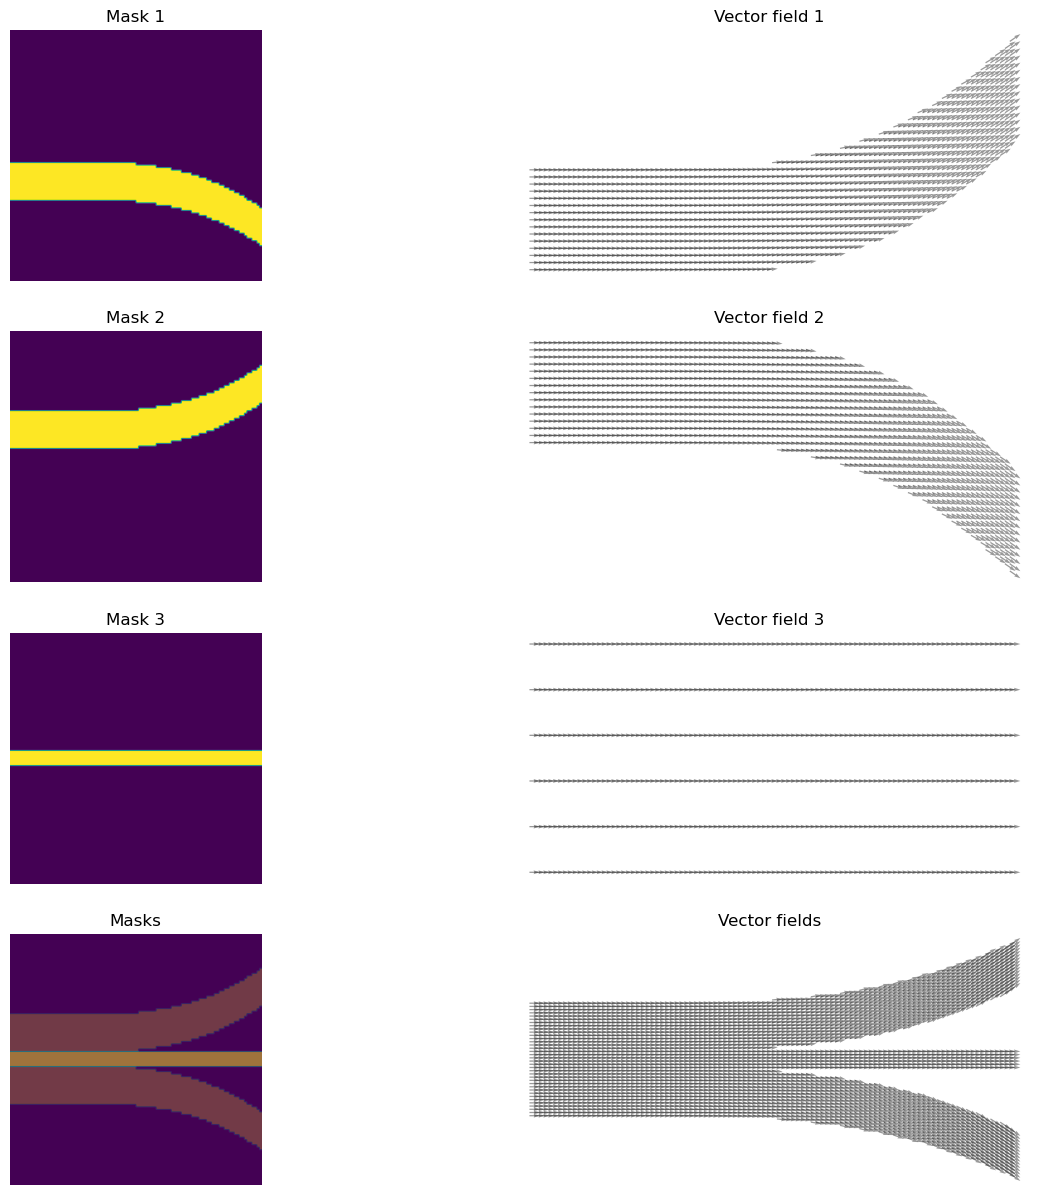

In [7]:
fig, axs = plt.subplots(n_fields + 1, 2, figsize=(15, 15))

x = np.linspace(0, height - 1, height)
y = np.linspace(0, width - 1, width)
yy, xx = np.meshgrid(x, y)

for ax in axs.ravel():
    ax.set_axis_off()

for i in range(n_fields):
    axs[i, 0].imshow(np.rot90(masks[i].T.cpu().numpy(), k=1))
    axs[i, 0].set_title(f'Mask {i + 1}')
    axs[i, 1].quiver(
        xx[masks[i].T.bool().cpu().numpy()],
        yy[masks[i].T.bool().cpu().numpy()],
        vector_fields[i][:, :, 0].cpu().numpy()[masks[i].T.bool().cpu().numpy()],
        vector_fields[i][:, :, 1].cpu().numpy()[masks[i].T.bool().cpu().numpy()],
        alpha=0.4,
        scale=50
    )
    axs[i, 1].set_title(f'Vector field {i + 1}')
    axs[-1, 0].imshow(masks[i].cpu().numpy(), alpha=1 if i == 0 else 0.5)
    axs[-1, 1].quiver(
        xx[masks[i].T.bool().cpu().numpy()],
        yy[masks[i].T.bool().cpu().numpy()],
        vector_fields[i][:, :, 0].cpu().numpy()[masks[i].T.bool().cpu().numpy()],
        vector_fields[i][:, :, 1].cpu().numpy()[masks[i].T.bool().cpu().numpy()],
        alpha=0.4,
        scale=50
    )

axs[-1, 0].set_title('Masks')
axs[-1, 1].set_title('Vector fields')

plt.show()

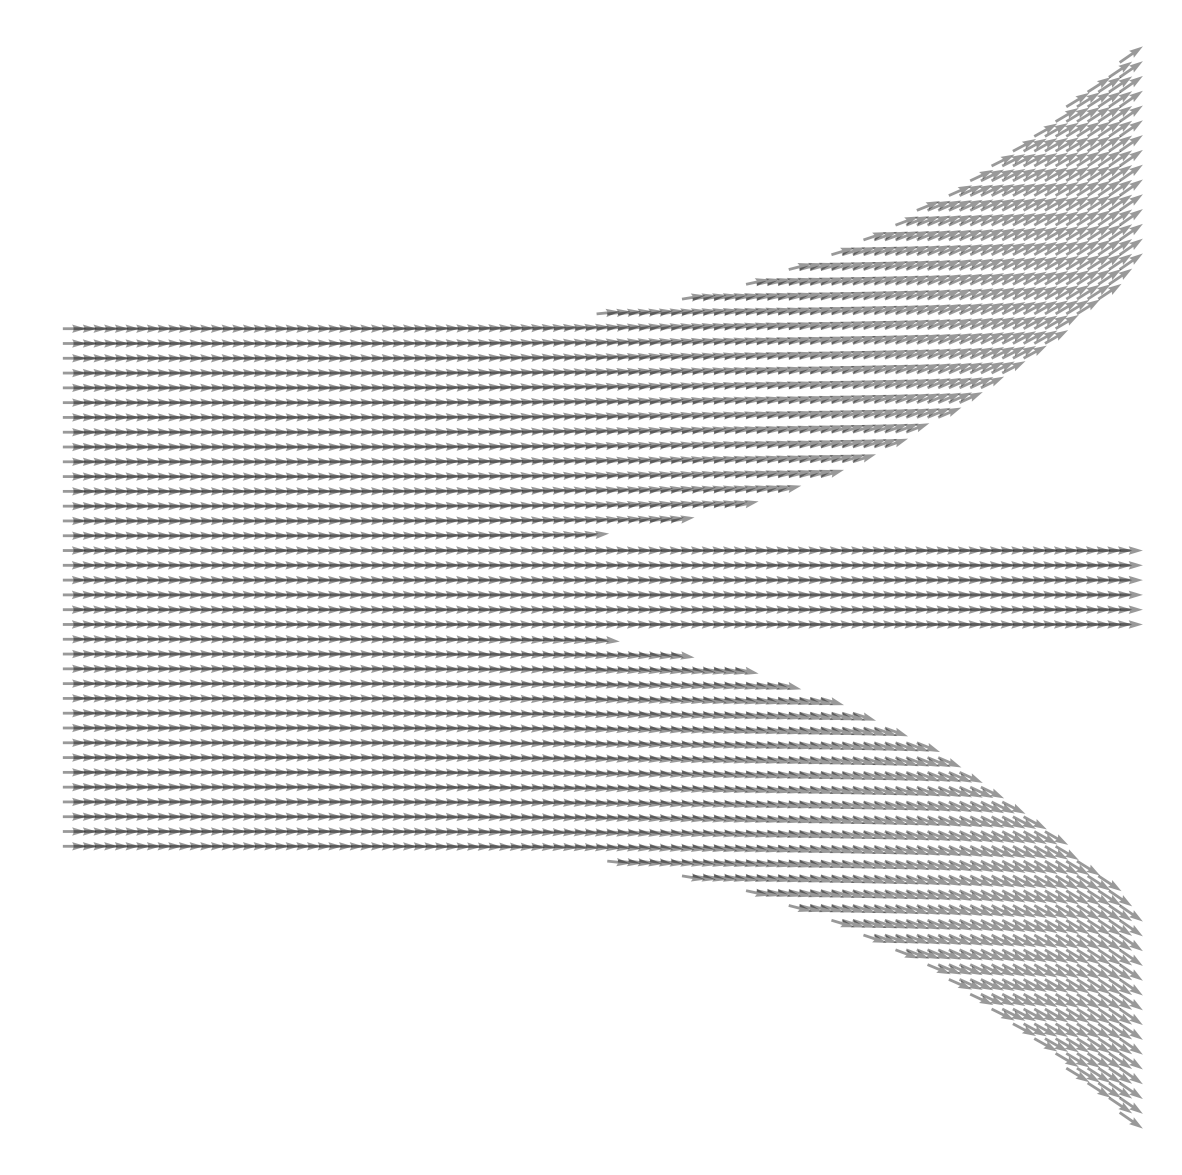

In [92]:
fig, ax = plt.subplots(figsize=(15, 15))

x = np.linspace(0, height - 1, height)
y = np.linspace(0, width - 1, width)
yy, xx = np.meshgrid(x, y)

ax.set_axis_off()

for i in range(n_fields):
    ax.quiver(
        xx[masks[i].T.bool().cpu().numpy()],
        yy[masks[i].T.bool().cpu().numpy()],
        vector_fields[i][:, :, 0].cpu().numpy()[masks[i].T.bool().cpu().numpy()],
        vector_fields[i][:, :, 1].cpu().numpy()[masks[i].T.bool().cpu().numpy()],
        alpha=0.4,
        scale=50
    )

axs[-1, 1].set_title('Vector fields')
plt.show()

# Training

In [30]:
epoch_loss_list = []
epoch_num = 2000
start_epoch_num = 0
learning_rate = 1e-4

model = DenseED(
    in_channels=2*n_fields,
    out_channels=3,
    imsize=100,
    blocks=[6, 8, 6],
    growth_rate=16,
    init_features=48,
    drop_rate=0,
    out_activation=None,
    upsample='nearest'
)
model.train()

criterion = torch.nn.MSELoss()
optimizer_id = torch.optim.Adadelta(model.parameters(), lr=learning_rate)

dataset_id = ImageDataset(vector_fields, masks)

dataloader_id = DataLoader(dataset_id, batch_size=1, shuffle=True, num_workers=0)

# params 751851, # conv layers 28


In [31]:
model = model.float().to(device)
for epoch in tqdm(range(start_epoch_num, start_epoch_num + epoch_num)):
    epoch_loss_id = 0

    for i, batched_id_sample in enumerate(dataloader_id):
        '''innerdomain backpropagate'''
        input_id = batched_id_sample['vector_field'].to(device).float()
        input_id.requires_grad = True
        # u_pred_id: [batch_size, *data_shape, feature_num] = [1, 3, ...]
        u_pred_id = model(input_id)
        # f_pred_id: [batch_size, feature_num, *data_shape] = [1, 2, ...]
        masks_id = [
            mask.squeeze()
            for mask in batched_id_sample['masks']
        ]

        pde_losses = [
            pde(u_pred_id.squeeze().double(), input_id[0, 2 * i:2 * (i + 1)].squeeze().double(), masks_id[i],
                differential_accuracy=2)
            for i in range(n_fields)
        ]

        f_preds = [
            torch.einsum('...ij,...ij->...ij', pde_loss, mask.unsqueeze(0).expand(2, -1, -1))
            for pde_loss, mask in zip(pde_losses, masks_id)
        ]

        f_pred_id = torch.cat(f_preds, 0)
        # f_true_id: [batch_size, feature_num, *data_shape] = [1, 2, ...]
        f_true_id = torch.zeros_like(f_pred_id)

        optimizer_id.zero_grad()
        loss_id = criterion(f_pred_id, f_true_id)
        loss_id.backward()
        epoch_loss_id += loss_id.item()
        optimizer_id.step()


    epoch_loss_list.append(epoch_loss_id)
    if epoch % 10 == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_id_state_dict': optimizer_id.state_dict(),
            'loss_id': epoch_loss_id
        }, f'models/model_02_tmp.pth.tar')

  0%|          | 0/2000 [00:00<?, ?it/s]

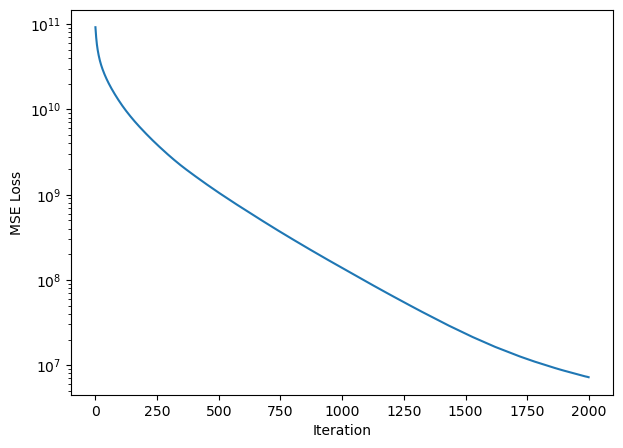

In [36]:
_, ax = plt.subplots(figsize=(7, 5))
ax.set_xlabel('Iteration')
ax.set_ylabel('MSE Loss')
ax.set_yscale('log')
ax.plot(epoch_loss_list)
plt.show()

# Plotting

In [85]:
checkpoint = torch.load(f'models/model_02_tmp.pth.tar')

geo_delta_t, euler_delta_t = 5e-3, 5e-3
geo_iters, euler_iters = int(1e6), int(1e6)

start_coords_list = [
    [[35, 54], ],
    [[35, 35], ],
    [[35, 48], [35, 51]],
]


model.load_state_dict(checkpoint['model_state_dict'])

mask = torch.where(torch.sum(torch.stack(masks), dim=0) > 0, 1, 0).permute(1, 0)
model = model.float()
u_pred = model(torch.cat([vector_field.permute(2, 0, 1).unsqueeze(0).float() for vector_field in vector_fields], 1))
u_pred = u_pred.squeeze()
s_pred = tensors.lin2mat(u_pred)

metric_pred_mat = matrix_exp_2d(s_pred)
metric_pred_lin = tensors.mat2lin(metric_pred_mat)

vector_lins = [
    vector_field.permute(2, 0, 1).cpu().numpy()
    for vector_field in vector_fields
]
tensor_pred_mat = np.linalg.inv(metric_pred_mat.detach().cpu().numpy())
tensor_pred_lin = tensors.mat2lin(tensor_pred_mat)

paths = [
    euler.eulerpath_vectbase_2d_w_dv(vector_lin, mask, start_coord, euler_delta_t, iter_num=euler_iters,
                                     both_directions=True)
    + geo.geodesicpath('f', tensor_pred_lin, vector_lin, mask, start_coord,
                       vector_lin[:, start_coord[0], start_coord[1]], geo_delta_t, iter_num=geo_iters,
                       both_directions=True)
    for start_coords, vector_lin in zip(start_coords_list, vector_lins)
    for start_coord in start_coords
]

Euler starting eigenvector: [-1.    -0.025]
Euler starting eigenvector: [1.    0.025]
Shooting geodesic path from [35, 54] with initial velocity [-1.    -0.025]
Shooting geodesic path from [35, 54] with initial velocity [1.    0.025]
Euler starting eigenvector: [-1.     0.025]
Euler starting eigenvector: [ 1.    -0.025]
Shooting geodesic path from [35, 35] with initial velocity [-1.     0.025]
Shooting geodesic path from [35, 35] with initial velocity [ 1.    -0.025]
Euler starting eigenvector: [-1. -0.]
Euler starting eigenvector: [1. 0.]
Shooting geodesic path from [35, 48] with initial velocity [-1. -0.]
Shooting geodesic path from [35, 48] with initial velocity [1. 0.]
Euler starting eigenvector: [-1. -0.]
Euler starting eigenvector: [1. 0.]
Shooting geodesic path from [35, 51] with initial velocity [-1. -0.]
Shooting geodesic path from [35, 51] with initial velocity [1. 0.]


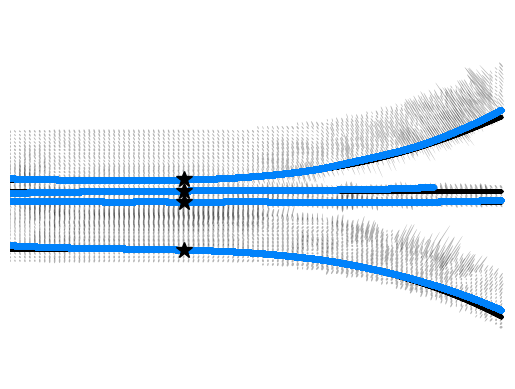

In [89]:
fig, ax = plt.subplots()
tens_fig = vis_tensors(metric_pred_lin.cpu().detach().cpu().cpu().numpy() * torch.stack((mask, mask, mask), 0).cpu().cpu().numpy(), '', False, scale=8e-1,
                       opacity=0.3, show_axis_labels=False, ax=ax)
for eulx, euly, _, _ in paths:
    disp_path(ax, eulx, euly, label="integral curve on vector field", color='black', size=2, alpha=1)

for _, _, geox_pred, geoy_pred in paths:
    disp_path(ax, geox_pred, geoy_pred, label=f"geodesic on learned", color='#0082fb', size=10, alpha=1)

for start_coords in start_coords_list:
    for start_coord in start_coords:
        ax.plot(start_coord[0], start_coord[1], linestyle='', marker='*', color='black', markersize=12)